# Damage Simulation

This notebook simulates the impact of storms on the efficiency of the transport network. For each storm swath, it removes a percentage of nodes using various strategies and recalculates travel times to measure the degradation in delivery efficiency.

## 0 Setup environment

In [1]:
import os
import re
import warnings
from glob import glob
from itertools import product

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from igraph import Graph
from joblib import Parallel, delayed
from shapely.geometry import Point
from tqdm import tqdm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
BASE_PATH = "data"
TRANSPORT_NETWORK_FILE = os.path.join(BASE_PATH, "merged_network_weighted.graphml")
CENTRALITY_FILE = os.path.join(BASE_PATH, "centrality_measures.csv")
TRAVEL_TIMES_FILE = os.path.join(BASE_PATH, "travel_times.csv")
SWATHS_DIR = os.path.join(BASE_PATH, "storm_swath_geometries")
RESULTS_DIR = os.path.join(BASE_PATH, "simulation_results_igraph")

os.makedirs(RESULTS_DIR, exist_ok=True)

N_STORMS = 200
DAMAGE_LEVELS = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
REMOVAL_STRATEGIES = ["degree", "betweenness", "closeness", "random"]

In [3]:
def load_graph():
    G = Graph.Read_GraphML(TRANSPORT_NETWORK_FILE)
    G.vs["osmid"] = [int(x) for x in G.vs["id"]]
    G.es["segment_time"] = [float(x) for x in G.es["segment_time"]]
    return G


def get_removable_nodes(ranked_nodes, damage_level):
    if not ranked_nodes:
        return []
    count = int((damage_level / 100) * len(ranked_nodes))
    return ranked_nodes[:count]

In [4]:
def compute_new_travel_times(graph, removed_osmids, origins, destinations):
    remaining_nodes = [v.index for v in graph.vs if v["osmid"] not in removed_osmids]
    graph_damaged = graph.subgraph(remaining_nodes)
    updated_idx_map = {v["osmid"]: i for i, v in enumerate(graph_damaged.vs)}
    travel_times = []
    for origin, destination in zip(origins, destinations):
        try:
            source = updated_idx_map[origin]
            target = updated_idx_map[destination]
            time = graph_damaged.distances(source, [target], weights="segment_time")[0][0]
            travel_times.append(np.inf if time is None else time)
        except (KeyError, IndexError):
            travel_times.append(np.inf)
    return travel_times


def compute_efficiency(base_times, new_times):
    base_times_arr = np.asarray(base_times)
    new_times_arr = np.asarray(new_times)
    n = base_times_arr.size
    if n == 0:
        return 0.0
    ratio = np.zeros_like(base_times_arr, dtype=float)
    with np.errstate(divide="ignore", invalid="ignore"):
        np.divide(base_times_arr, new_times_arr, out=ratio, where=new_times_arr != 0)
    log_term = np.log2(1 + ratio)
    return np.sum(log_term) / n

In [5]:
def run_storm_task(G, base_times, origins, destinations, sid, ranked_nodes, strategy, level):
    nodes_to_remove = get_removable_nodes(ranked_nodes, level)
    new_times = compute_new_travel_times(G, nodes_to_remove, origins, destinations)
    efficiency = compute_efficiency(base_times, new_times)
    return {
        "storm_id": sid,
        "node_removal_strategy": strategy,
        "damage_level": level,
        "delivery_efficiency": efficiency,
    }

In [6]:
def process_storm(storm_id, nodes_in_swaths, df_centrality, origins, destinations, base_times, G):
    result_file = os.path.join(RESULTS_DIR, f"storm_{storm_id}.csv")

    swath_nodes = nodes_in_swaths[nodes_in_swaths["SID"] == storm_id].index.tolist()
    protected_nodes = set(origins) | set(destinations)
    removable_nodes = [node for node in swath_nodes if node not in protected_nodes]

    ranked_nodes = {}
    if removable_nodes:
        centrality_nodes = df_centrality.loc[removable_nodes]
        for strategy in ["degree", "betweenness", "closeness"]:
            ranked_nodes[strategy] = centrality_nodes[strategy].sort_values(ascending=False).index.tolist()
        ranked_nodes["random"] = list(np.random.permutation(removable_nodes))
    else:
        for strategy in REMOVAL_STRATEGIES:
            ranked_nodes[strategy] = []

    task_args = [
        (G, base_times, origins, destinations, storm_id, ranked_nodes[strategy], strategy, level)
        for strategy, level in product(REMOVAL_STRATEGIES, DAMAGE_LEVELS)
    ]

    results = Parallel(n_jobs=-1, backend="loky")(delayed(run_storm_task)(*args) for args in task_args)

    df_result = pd.DataFrame(results)
    df_result.to_csv(result_file, index=False)

## 1 Load baseline data

In [7]:
G = load_graph()

gdf_nodes = gpd.GeoDataFrame(
    {
        "osmid": G.vs["osmid"],
        "geometry": [Point(v["x"], v["y"]) for v in G.vs],
    },
    crs="EPSG:4326",
)
gdf_nodes = gdf_nodes.set_index("osmid")

swath_files = glob(os.path.join(SWATHS_DIR, "*.gpkg"))
gdf_swaths = pd.concat([gpd.read_file(f) for f in swath_files], ignore_index=True).head(N_STORMS)
nodes_in_swaths = gpd.sjoin(gdf_nodes, gdf_swaths, how="inner", predicate="within")

df_centrality = pd.read_csv(CENTRALITY_FILE).set_index("osmid")
df_travel_times = pd.read_csv(TRAVEL_TIMES_FILE)
base_travel_times = df_travel_times["travel_time"].values
origin_nodes = df_travel_times["origin_node"].values
destination_nodes = df_travel_times["destination_node"].values

## 2 Run simulation

In [8]:
storms_done = {
    match.group(1)
    for f in glob(os.path.join(RESULTS_DIR, "storm_*.csv"))
    if (match := re.search(r"storm_(.+)\.csv$", f))
}

storms_all = gdf_swaths["SID"].unique()
storms_pending = [sid for sid in storms_all if sid not in storms_done]

for sid in tqdm(storms_pending, desc="Simulating storms"):
    process_storm(
        sid,
        nodes_in_swaths,
        df_centrality,
        origin_nodes,
        destination_nodes,
        base_travel_times,
        G,
    )

Simulating storms: 0it [00:00, ?it/s]

## 3 Analyze results

In [9]:
df_results = pd.concat(
    (pd.read_csv(f) for f in glob(os.path.join(RESULTS_DIR, "storm_*.csv"))),
    ignore_index=True,
)

df_results_agg = df_results.groupby(["node_removal_strategy", "damage_level"])
df_results_agg = df_results_agg["delivery_efficiency"].mean().round(3).reset_index()

df_results_agg.to_csv(os.path.join(BASE_PATH, "simulation_results.csv"), index=False)

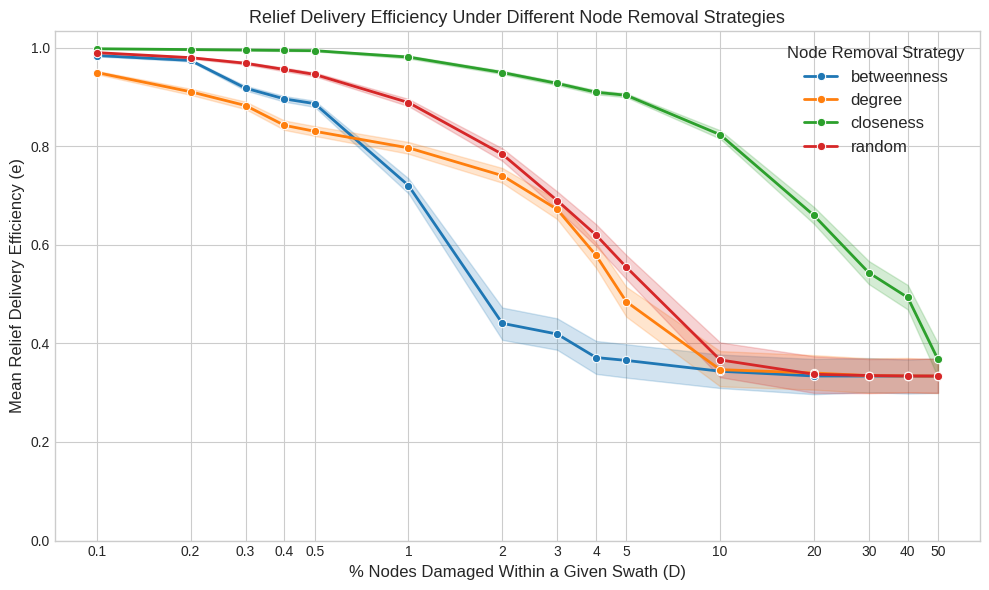

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")
_, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=df_results,
    x="damage_level",
    y="delivery_efficiency",
    hue="node_removal_strategy",
    ax=ax,
    linewidth=2,
    hue_order=["betweenness", "degree", "closeness", "random"],
    errorbar=("ci", 75),
    marker="o",
)

ax.set_title("Relief Delivery Efficiency Under Different Node Removal Strategies", fontsize=13)
ax.set_xlabel("% Nodes Damaged Within a Given Swath (D)", fontsize=12)
ax.set_ylabel("Mean Relief Delivery Efficiency (e)", fontsize=12)
ax.set_xscale("log")
ax.set_xticks(DAMAGE_LEVELS, labels=DAMAGE_LEVELS)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend(title="Node Removal Strategy", title_fontsize="12", fontsize="12")

plt.savefig(os.path.join(BASE_PATH, "damage_simulation.png"), dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()